In [2]:
import torch
import numpy as np

import os, sys
project_root_dir = os.path.join(os.getcwd(),'../..')
if project_root_dir not in sys.path:
    sys.path.append(project_root_dir)
    import config

In [46]:
save_dir = os.path.join(config.RESULTS_DIR, 'Chapter6/LaparoscopyHSIBandSelection/other/Metrics/')

In [55]:
from FeatureSelection.Experiments.LaparoscopyHSIBandSelection import ExperimentFactory, ExperimentType
factory = ExperimentFactory()
exp = factory.create_experiment(ExperimentType.Concrete_3, reg_factor=2)

<All keys matched successfully>

In [76]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def metrics_result(exp):
    model = exp.model
    test = exp.test_dataset

    with torch.no_grad():
        model.eval()
        X, y = test[:]
        _X = model(X)
        y_pred = _X.argmax(dim=1).cpu().numpy()
        y_true = y.cpu().numpy()


    metrics_df = pd.DataFrame({
        'accuracy': [accuracy_score(y_true, y_pred)],
        'precision': [precision_score(y_true, y_pred, average='macro')],
        'recall': [recall_score(y_true, y_pred, average='macro')],
        'f1': [f1_score(y_true, y_pred, average='macro')]
    })

    return metrics_df

def confusion_matrix_result(exp, normalize=False):
    model = exp.model
    test = exp.test_dataset

    with torch.no_grad():
        model.eval()
        X, y = test[:]
        _X = model(X)
        y_pred = _X.argmax(dim=1).cpu().numpy()
        y_true = y.cpu().numpy()

    labels = ['Fat', 'Muscle', 'Nerve', 'Vessel']
    cm = confusion_matrix(y_true, y_pred, normalize='true' if normalize else None)
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)

    return cm_df

def confusion_matrix_figure(exp):
    cm_df = confusion_matrix_result(exp, normalize=True)

    sns.set()
    fig = plt.figure(figsize=(6,4))
    # heatmap with labels
    ax = sns.heatmap(cm_df, annot=True, cmap='Blues')
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([0, 0.25, 0.5, 0.75, 1])

    plt.xlabel('Predicted')
    plt.ylabel('True')

    return fig

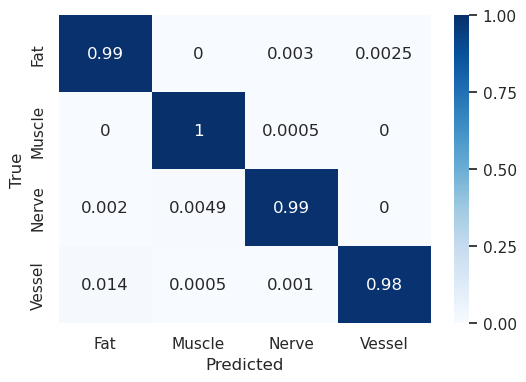

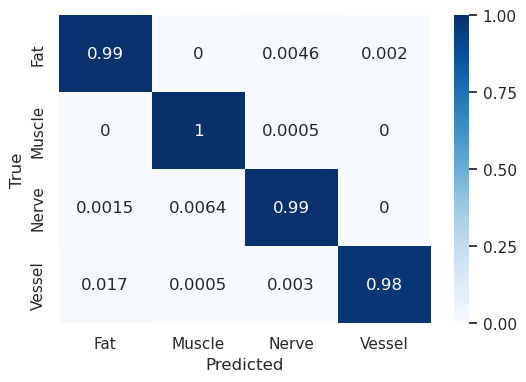

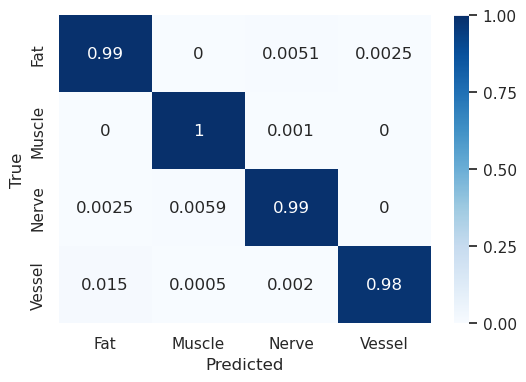

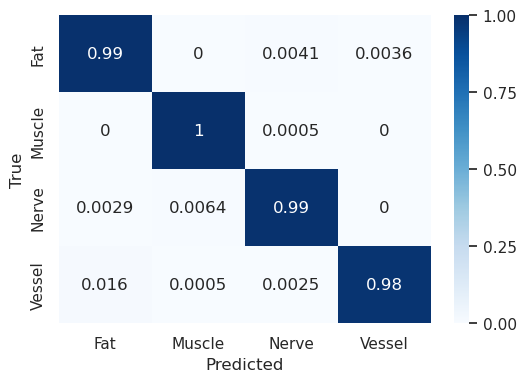

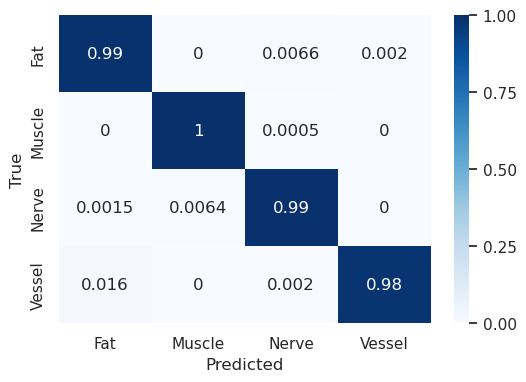

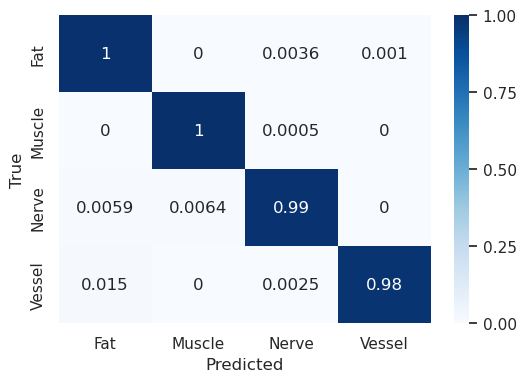

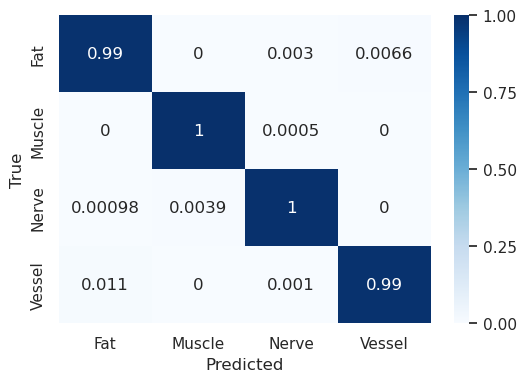

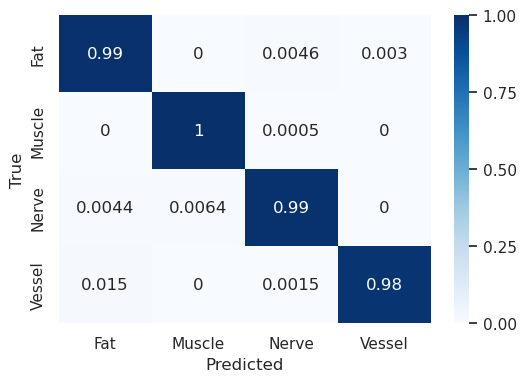

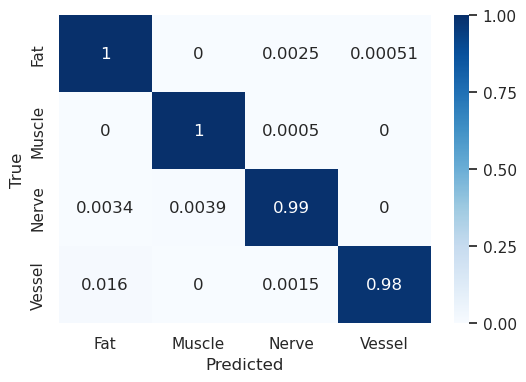

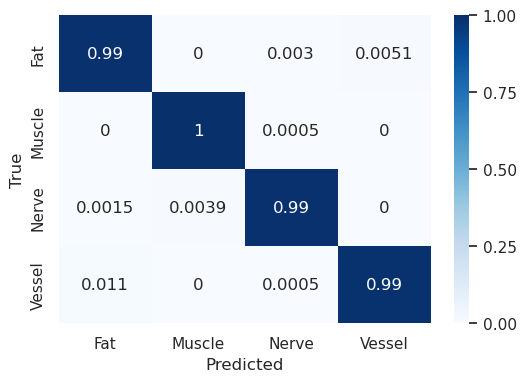

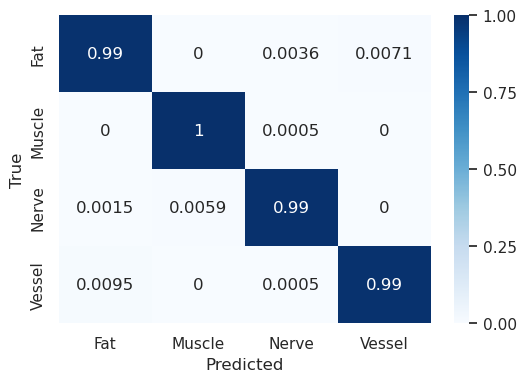

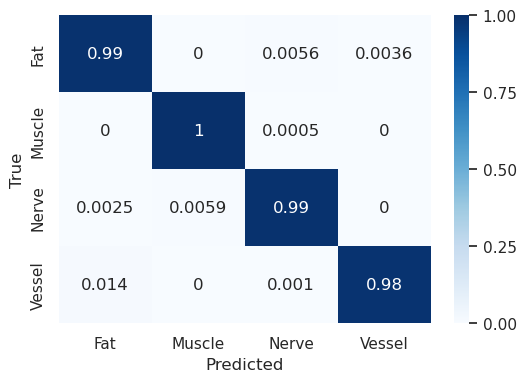

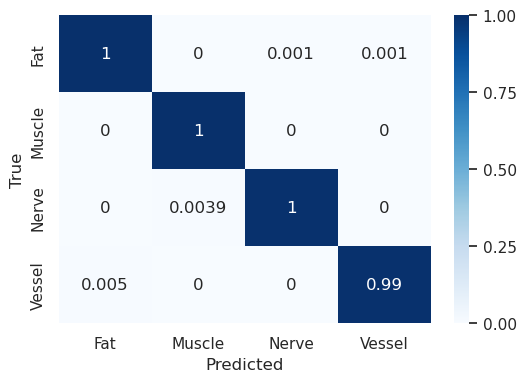

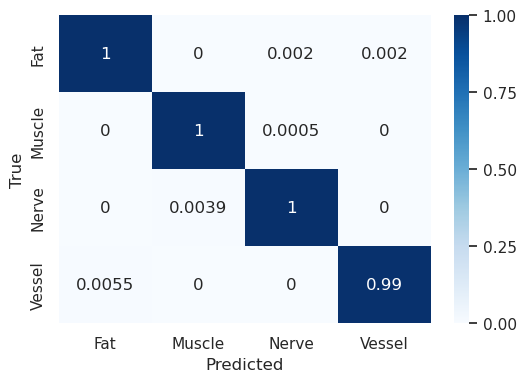

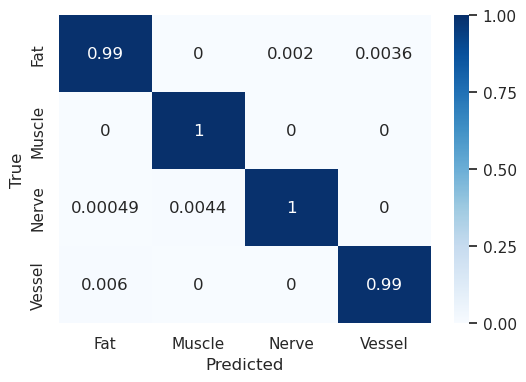

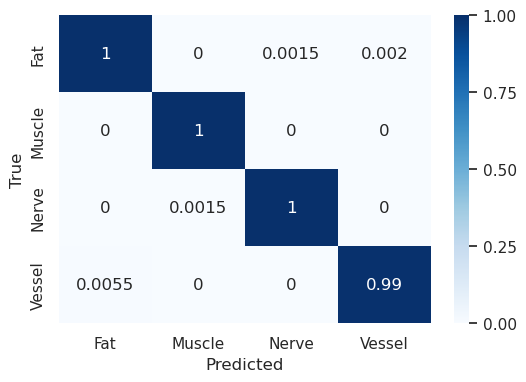

In [77]:
experiments = [ExperimentType.Concrete_2, ExperimentType.Concrete_3, ExperimentType.Concrete_5, ExperimentType.Gaussian_5]
_lambda = [1, 1.5, 2, 3]

for exp_type in experiments:
    for reg in _lambda:
        exp = factory.create_experiment(exp_type, reg_factor=reg)

        from FeatureSelection.StochasticGate  import ConcreteFeatureSelector
        weights_file = 'concrete.pt' if isinstance(exp.model.feature_selector, ConcreteFeatureSelector) else 'gaussian.pt'
        weights = torch.load(os.path.join(exp.config()['save_model_dir'], weights_file))
        exp.model.load_state_dict(weights)

        metrics_df = metrics_result(exp)
        cm_df = confusion_matrix_result(exp)

        save_dir = os.path.join(exp.config()['save_result_dir'], 'metrics')
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        metrics_df.to_csv(os.path.join(save_dir, 'metrics.csv'), index=False)
        cm_df.to_csv(os.path.join(save_dir, 'confusion_matrix.csv'), index=False)

        fig = confusion_matrix_figure(exp)
        fig.savefig(os.path.join(save_dir, 'confusion_matrix.pdf'), bbox_inches='tight')